In [ ]:
#Authors:Group 9
    #Beiyang Yu (5353653)
    #Mazen Alqadi (476578)
    #Tianyang Lu (5215277)
    #Xilin Yin (5271649)

In [88]:
import numpy as np
import math
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.integrate as spint
%matplotlib inline

In [89]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")

In [90]:
doc1 = pd.read_csv('WieringermeerData_Meteo.csv')   # Read the measured data
print(doc1.keys())

Index(['datetime', 'rain_station', 'pEV', 'temp'], dtype='object')


In [92]:
Jrf = np.zeros(2757, dtype=float)
E = np.zeros(2757, dtype=float)
Jrf[0:2757] = doc1.iloc[3451:6208,1]
E[0:2757] = doc1.iloc[3451:6208,2]
# Initialization of J and E matrix

Jrf_ = np.zeros(2757, dtype=float)
E_ = np.zeros(2757, dtype=float)

for i in range (0, 2757):
        Jrf_[i] = Jrf[i]
        E_[i] = E[i]

array([0.    , 0.    , 0.0075, ..., 0.    , 0.    , 0.    ])

In [93]:
acl = 0.007     # 0.005~0.01
awb = 0.0008    # 0.0005~0.001
Scl_max = 0.60  # 0.45~0.975
Swb_max = 7.0   # 4.5~7.8
Scl_min = 0     
Swb_min = 0
beta0 = 0.98    # 0~1
Cf = 0.92       # 0~1.4
fred = 1.0
bcl = 5         # 0~80
bwb = 30        # 0~80
def dYdt(t, Y):
    a = math.ceil(t)
    return np.array([Jrf[a-1] - acl * ((Y[0] - Scl_min) / (Scl_max - Scl_min)) ** bcl -  E[a-1] * Cf * fred,
                    (1 - beta0 * (Y[0] - Scl_min) / (Scl_max - Scl_min)) * acl * ((Y[0] - Scl_min) / (Scl_max - Scl_min)) ** bcl - awb * ((Y[1] - Swb_min) / (Swb_max - Swb_min)) ** bwb])
# Definition of the ODE 

In [94]:
tOut = np.linspace(0, 2757, 2757)    #6209 points calculated but only 2757 are used
nOut = np.shape(tOut)[0]
t_span = [tOut[0], tOut[-1]]     


2757

In [96]:
doc2 = pd.read_csv('WieringermeerData_LeachateProduction.csv')     #Read the Q datafile
Q_dr = doc2.iloc[:,1]

Q_cal = np.zeros(2757)     #Initialization of Q_cal
Q_rate = np.zeros(2757)    #Initialization of Q_rate for calculating Q_drmean

Q_rate[0] =  0.
for i in range (1, 2757):
    Q_rate[i] = Q_dr[i] - Q_dr[i-1]
Q_drmean = np.mean(Q_rate)

print(Q_rate)
print(Q_drmean)

[ 0.          6.09999847 10.79999543 ... 33.70313    38.39844
 36.39843   ]
23.775951269495827


In [98]:
num = 0            # Counter for NSE
step= 20           # Step for the variable coefficient
#NSE = np.zeros(step, dtype=float)     # Initialization of NSE array
NSE_ = 0
# Set up the initial value
Y0 = np.array([Scl_max / 1.547, Swb_max / 1.035])


for j in range(0, step):
    
    Scl_max = 0.45 + 0.025 * j   # Variable parameters
    
    res = spint.solve_ivp(dYdt, t_span, Y0, t_eval=tOut, vectorized=True,
                          method='RK45', rtol=1e-5)
    Y = res['y']
    rODE = Y[0,:]
    fODE = Y[1,:]
        
    Q_cal = np.zeros(2757)
    Q_cal = beta0 * ((rODE - Scl_min) / (Scl_max - Scl_min)) * acl * ((rODE - Scl_min) / (Scl_max - Scl_min)) ** bcl + awb * ((fODE - Swb_min) / (Swb_max - Swb_min)) ** bwb
    Q_cal = Q_cal * 28355    
    
    divided = 0
    denominator = 0    
    for T in range(2757):
        divided += (Q_rate[T] - Q_cal[T]) ** 2
        denominator += (Q_rate[T] - Q_drmean) ** 2
    NSE_ = 1 - divided / denominator
    NSE[num] = NSE_
    NSE_ = 0 
    num += 1
    # Calculate the NSE of variable parameters
    
print(Scl_max)
print(divided)
print(denominator)
print(rODE)
print(NSE_)

C:\Users\Yu Beiyang\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in power
  from ipykernel import kernelapp as app


0.6
394195.29513192084
1263315.5535246204
[0.38784745 0.3845959  0.38137275 ... 0.46189024 0.45981142 0.45762167]
0.6879676704429663


Text(0, 0.5, 'NSE')

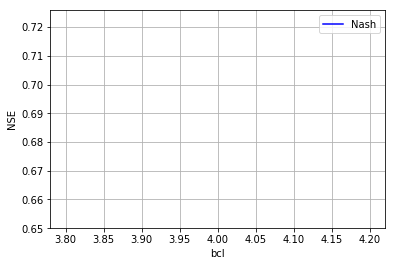

In [84]:
Scl_max = np.linspace(0.45, 0.925,step)

plt.figure()
plt.plot(Scl_max, NSE, 'b-', label='Nash')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Scl_max')
plt.ylabel('NSE')
# Plot the NSE over variable parameters

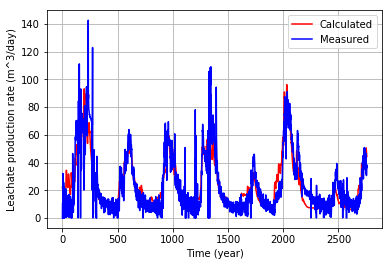

In [85]:
plt.figure()
plt.plot(tOut, Q_cal, 'r-', label='Calculated')
plt.plot(tOut, Q_rate, 'b-', label='Measured')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Time (year)')
plt.ylabel('Leachate production rate (m^3/day)')
plt.show()